0 0


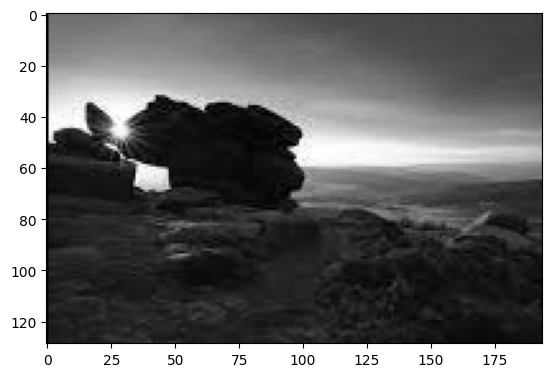

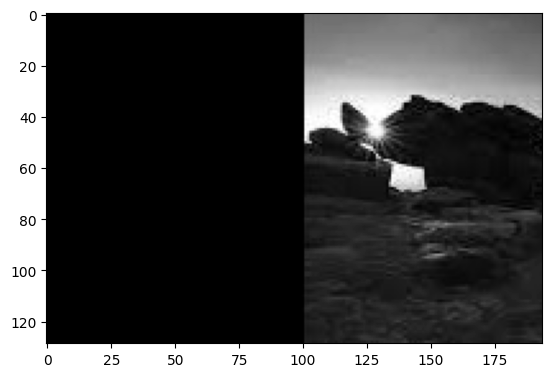

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def ReadImage(filename,toGrayscale=False):
    img = []
    if(toGrayscale):
        img = Image.open(filename).convert('L')
    else:
        img = Image.open(filename)
    img = np.array(img)
    return img

def derX(image):
    derX = np.zeros(image.shape)
    return convolve2d(image, [[1,-1]], mode='same',boundary='symm')

def derY(image):
    derY = np.zeros(image.shape)
    return convolve2d(image, [[1],[-1]], mode='same',boundary='symm')

def calculateDif(im1,im2,u,v):
    empty = np.zeros(im2.shape)
    ru = int(np.round(u))
    rv = int(np.round(v))
    h,w = im1.shape
    if ru> 0:
        if rv>0:
            empty[ru:,rv:] = im2[ru:,rv:] - im1[h-ru:,:w-rv]
        else:
            empty[ru:,:w+rv] = im2[ru:,:w+rv] - im1[:h-ru,-rv:]
    else:
        if rv>0:
            empty[:h+ru,rv:] = im2[:h+ru,rv:] - im1[-ru:,:w-rv]
        else:
            empty[:h+ru,:w+rv] = im2[:h+ru,:w+rv] - im1[-ru,-rv:]
    return empty


def calculateDis(im1,im2):
    der_x = derX(im2) 
    der_y= derY(im2) 
    u = 0
    v = 0
    h,w = im1.shape

    A = np.matrix([
        [np.sum(der_x*der_x),np.sum(der_x*der_y)],
        [np.sum(der_x*der_y),np.sum(der_y*der_y)]
    ])
    It = im2 - im1
    min_val = abs(np.sum(It)/((h-abs(u))*(w-abs(v))))+1
    while(min_val <= np.sum(It)/((h-abs(u))*(w-abs(v)))):
        b = np.matrix([[np.sum(der_x*It,)],[np.sum(der_y*It)]])
        x=np.linalg.solve(A,-b)
        min_val= np.sum(It)/((h-abs(u))*(w-abs(v)))
        v+= np.sum(x[0])
        u+= np.sum(x[1])
        It=calculateDif(im1,im2,u,v)
        if(abs(u) > h or abs(v) > w ):
            break
    return u,v
    

im1 = ReadImage("im2.jpeg",True)
# im2 = ReadImage("im2.jpeg",True)
im2 = np.pad(im1[:,:-100],((0,0),(100,0)))
u,v = calculateDis(im2,im1)
print(u,v)
plt.imshow(im1,cmap='gray')
plt.show()
plt.imshow(im2,cmap='gray')
plt.show()

KeyboardInterrupt: 

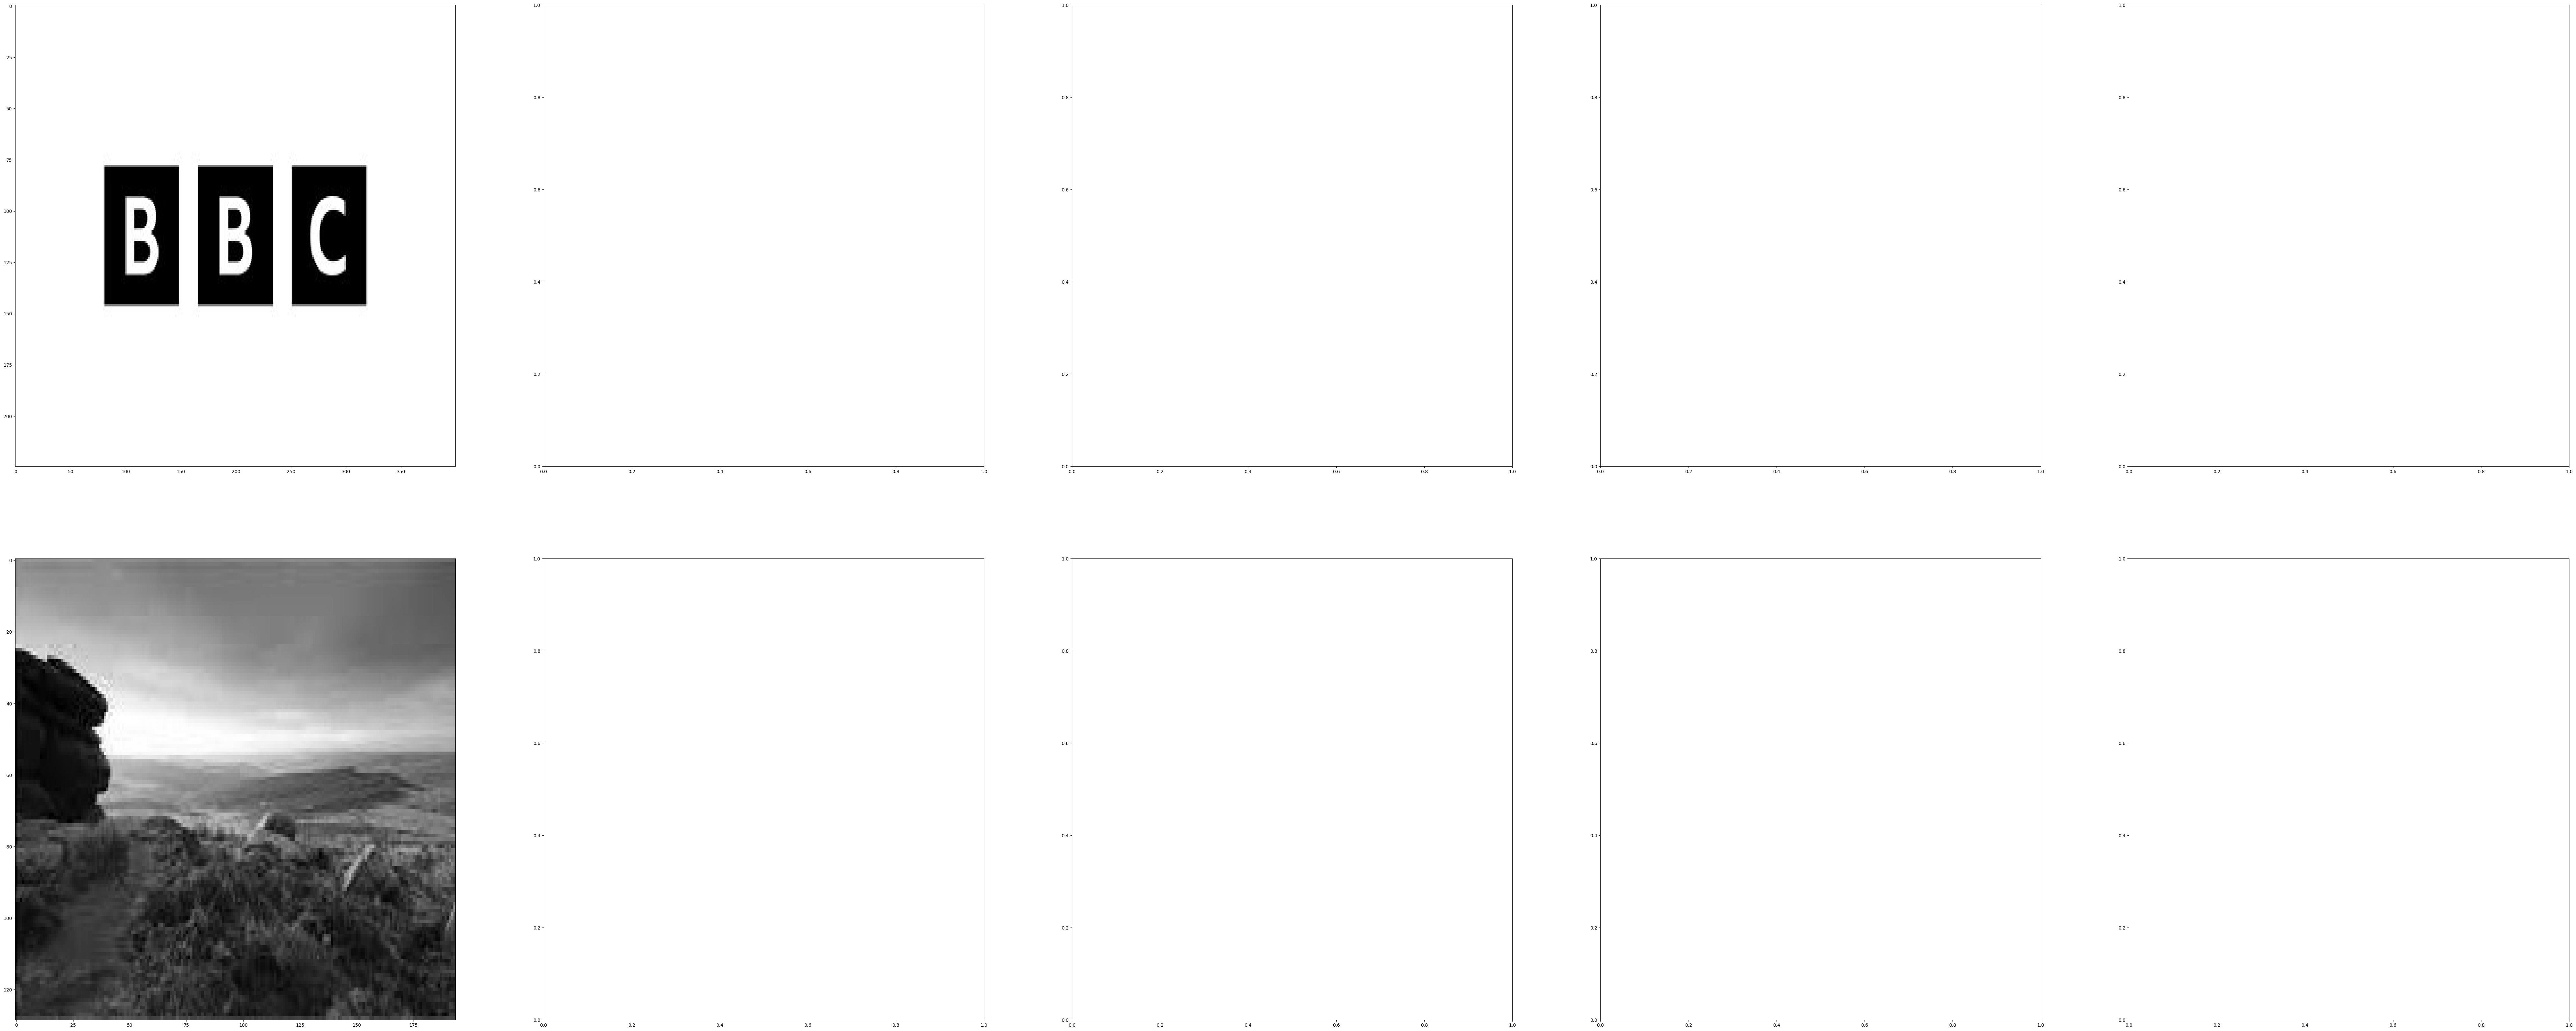

In [152]:
def HarrisCornerDedection(image,k = 0.04,window_size=5):
    emp = np.zeros(image.shape)
    for i in range(window_size//2,image.shape[0]-window_size//2):
        for j in range(window_size//2,image.shape[1]-window_size//2):
            der_x = derX(image[i-window_size//2:i+window_size//2+1,j-window_size//2:j+window_size//2+1])
            der_y = derY(image[i-window_size//2:i+window_size//2+1,j-window_size//2:j+window_size//2+1])
            M = np.matrix([[np.sum(der_x**2),np.sum(der_x*der_y)],[np.sum(der_x*der_y),np.sum(der_y**2)]])
            emp[i,j] = np.linalg.det(M)-k*(np.trace(M)**2)
    for i in range(2,emp.shape[0]-2):
        for j in range(2,emp.shape[1]-2):
            if(emp[i,j] < np.max(emp[i-1:i+2,j-1:j+2])):
                emp[i,j] = 0
    return np.where(emp > 0.1*np.max(emp))

im1 = ReadImage("BBC.jpeg",True)
im2 = ReadImage("im1.jpeg",True)
f,axis = plt.subplots(2,5,figsize=(100,40))
axis[0,0].imshow(im1,cmap='gray',aspect='auto')
axis[1,0].imshow(im2,cmap='gray',aspect='auto')
for i in range(1,5):
    im1_corners = np.zeros(im1.shape)
    im2_corners = np.zeros(im2.shape)
    im1_corners[HarrisCornerDedection(im1,window_size=5*i)]=255
    im2_corners[HarrisCornerDedection(im2,window_size=5*i)]=255
    axis[0,i].imshow(im1_corners,cmap='gray',aspect='auto')
    axis[1,i].imshow(im2_corners,cmap='gray',aspect='auto')
plt.show()

We are familliay with the gaussian blue function $f(x) = \frac{1}{\sigma \sqrt{2 \pi}} \cdot e^{-\frac{x^2}{2\sigma^2}}$
so we want to calculate the $f_{\sigma_1}(x-y)\cdot f_{\sigma_2}(I_x-I_y)=\frac{1}{\sigma_1 \sqrt{2 \pi}} \cdot e^{-\frac{(x-y)^2}{2\sigma_1^2}} \cdot \frac{1}{\sigma_2 \sqrt{2 \pi}} \cdot e^{-\frac{(I_x-I_y)^2}{2\sigma_2^2}}$ <br>
and we can simplefy it as $f(x,y) = \frac{1}{\sigma_1 \cdot \sigma_2 2 \pi }e^{-\frac{(x-y)^2(I_x-I_y)^2}{4\sigma_1^2\sigma_2^2}}$

In [ ]:
def blurGaussian(image,sigma):
    image_fft = np.fft.fftshift(np.fft.fft2(image))
    guassian = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            guassian[i,j] = np.exp(-((i**2+j**2)/(2*sigma**2)))/(2*np.pi*sigma**2)
    guassian = np.fft.fftshift(guassian)
    return np.abs(np.fft.ifft2(np.fft.ifftshift(image_fft*guassian)),dtype='float')

def SIFT(image):
    

im1 = ReadImage("im1.jpeg",True)
plt.imshow(blurGaussian(im1,80),cmap='gray')
plt.show()
    


IndentationError: expected an indented block (1964276351.py, line 13)

1


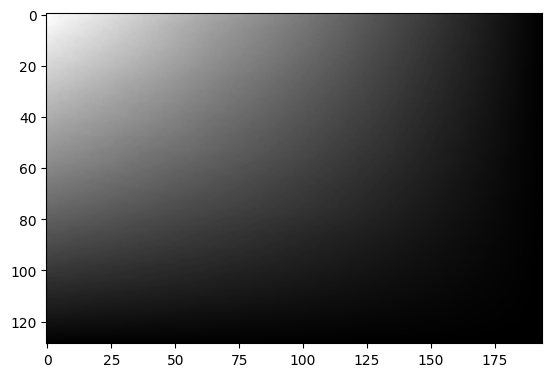

9 63


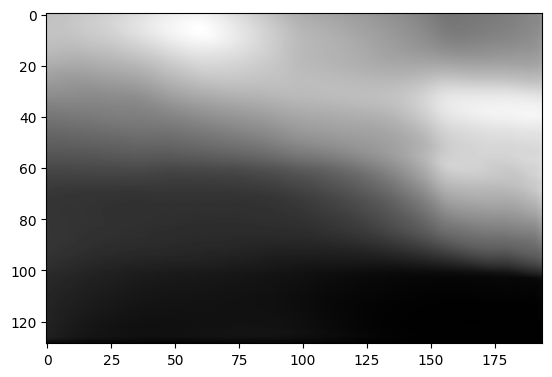

In [ ]:
def cross_coralation(im1,im2):
    emp = np.zeros(im1.shape)
    h,w = im1.shape
    for u in range(im1.shape[0]):
        for v in range(im1.shape[1]):
            emp[u,v] = np.sum(im1[:h-u,:w-v]*im2[u:,v:])
    print(np.argmax(emp))
    return emp

def normal_cross_coralation(im1,im2):
    emp = np.zeros(im1.shape)
    h,w = im1.shape
    for u in range(im1.shape[0]):
        for v in range(im1.shape[1]):
            emp[u,v] = np.sum((im1[:h-u,:w-v]-np.mean(im1))*(im2[u:,v:]-np.mean(im2)))/((np.sum((im1[:h-u,:w-v]-np.mean(im1))**2)*np.sum((im2[u:,v:]-np.mean(im2))**2))**0.5)
    print(np.argmax(emp)//h,np.argmax(emp)%h)
    return emp

im1 = ReadImage("im1.jpeg",True)
im2 = ReadImage("im2.jpeg",True)
plt.imshow(cross_coralation(im1,im2),cmap='gray')
plt.show()
plt.imshow(normal_cross_coralation(im1,im2),cmap='gray')
plt.show()


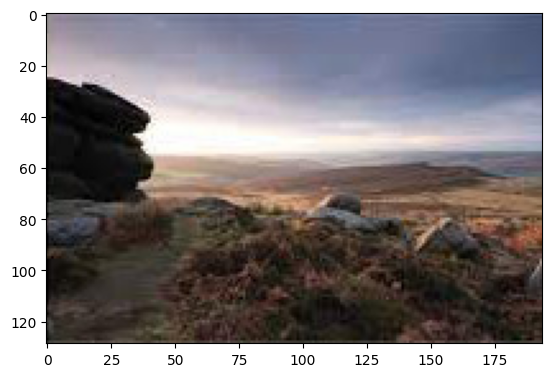

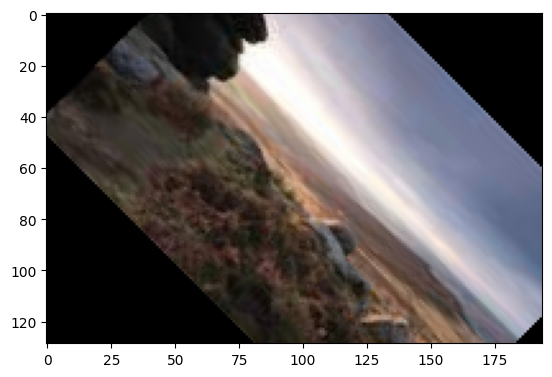

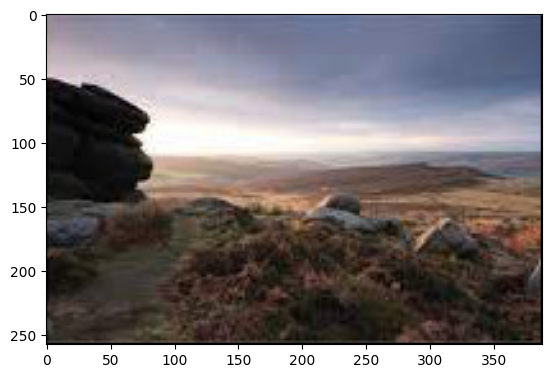

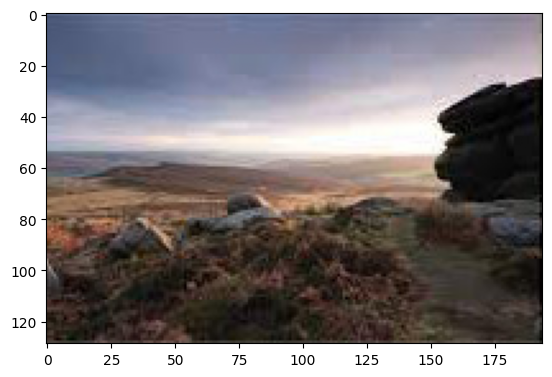

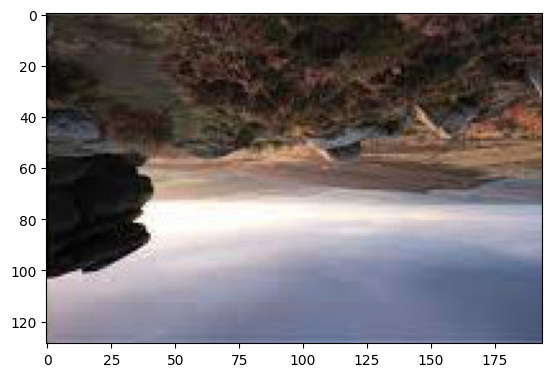

In [191]:
from 



im1 = ReadImage("im1.jpeg")
plt.imshow(im1)
plt.show()
plt.imshow(rotate(im1,np.pi/4,(100,80)))
plt.show()
plt.imshow(scale(im1,2,2,'full'))
plt.show()
plt.imshow(flipX(im1))
plt.show()
plt.imshow(flipY(im1))
plt.show()

In [195]:
np.kron(, np.matrix([[1,0],[0,0]]))

matrix([[135,   0, 133,   0, 134,   0],
        [  0,   0,   0,   0,   0,   0],
        [149,   0, 144,   0, 148,   0],
        ...,
        [  0,   0,   0,   0,   0,   0],
        [ 93,   0, 106,   0, 138,   0],
        [  0,   0,   0,   0,   0,   0]])